In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T
import torchvision.models.segmentation as models
from torchvision.models.optical_flow import raft_small, raft_large

from lumivid.sky_ground_segmentation.train import get_model as get_ground_model
from lumivid.utils.video_utils import get_video, get_video_frame_iterator
from lumivid.utils.model_utils import load_model

DATA_PATH = '../data/'

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def get_ground_mask(
        frame,
        model_type = 'deeplabv3mobilenetv3large',
        optimizer_type = 'ranger'
        ):
    model_save_path = f"../data/sky_ground_segmentation/models/{model_type}_{optimizer_type}_pretrained.pth"
    ground_model = get_ground_model(model_type, n_classes=2, pretrained=False)

    # Predict the ground mask using frame
    frame = frame[:, :, ::-1] # BGR to RGB
    frame = (frame / 255.0 - IMAGENET_MEAN) / IMAGENET_STD # Normalize
    frame = torch.tensor(frame).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE) # To tensor
    load_model(ground_model, model_save_path, force=True)

    ground_model.eval()
    ground_mask = ground_model(frame)['out'].cpu().detach().numpy().squeeze()
    ground_mask = np.argmax(ground_mask, axis=0)

    return ground_mask.astype(bool)

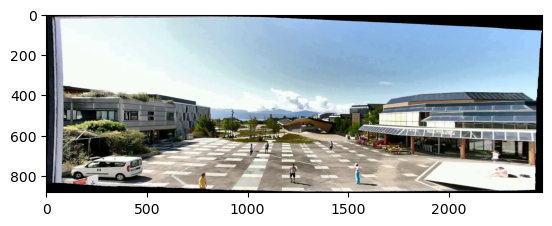

In [5]:
video_path = DATA_PATH + f"preprocessing/processed_scenes/P1Scene03.mp4"
video = get_video(video_path)
frame_it = get_video_frame_iterator(
        video, 
        frame_step=1,
        split = False,
        masked = True,
        reframed = True,
        undistort = True
    )
frame, _ = next(frame_it)
frame = frame[:, :, ::-1]

plt.imshow(frame)
plt.show()

[ 0  6  7 15 19]


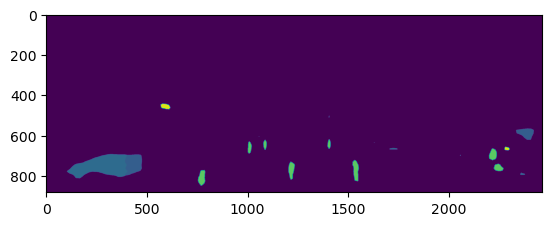

In [5]:
model = models.deeplabv3_mobilenet_v3_large(
        weights='COCO_WITH_VOC_LABELS_V1',
        weights_backbone='IMAGENET1K_V2',
        progress=True,
        num_classes=21,
        aux_loss=True
    ).to(DEVICE)

model.eval()
frame_tensor = (frame / 255.0 - IMAGENET_MEAN) / IMAGENET_STD # Normalize
frame_tensor = torch.tensor(frame_tensor).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE) # To tensor
out = model(frame_tensor)['out'].cpu().detach().numpy().squeeze()
out = np.argmax(out, axis=0)

print(np.unique(out))

plt.imshow(out, vmin=0, vmax=20)
plt.show()

In [6]:
label_map = np.array([
    (0, 0, 0),  # background
    (128, 0, 0),  # aeroplane
    (0, 128, 0),  # bicycle
    (128, 128, 0),  # bird
    (0, 0, 128),  # boat
    (128, 0, 128),  # bottle
    (0, 128, 128),  # bus
    (128, 128, 128),  # car
    (64, 0, 0),  # cat
    (192, 0, 0),  # chair
    (64, 128, 0),  # cow
    (192, 128, 0),  # dining table
    (64, 0, 128),  # dog
    (192, 0, 128),  # horse
    (64, 128, 128),  # motorbike
    (192, 128, 128),  # person
    (0, 64, 0),  # potted plant
    (128, 64, 0),  # sheep
    (0, 192, 0),  # sofa
    (128, 192, 0),  # train
    (0, 64, 128),  # tv/monitor
])

# Convert Segmentation Output to RGB using label_map
segmentation_rgb = np.zeros((out.shape[0], out.shape[1], 3), dtype=np.uint8)
for i in range(21):
    segmentation_rgb[out == i] = label_map[i]

# Overlay the Segmentation Mask on the Original Frame
alpha = 0.7  # Transparency factor
overlayed_image = np.uint8(frame * (1-alpha) + segmentation_rgb * alpha)

# Display the Overlayed Image
plt.imshow(overlayed_image)

# Create a Legend
classes = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'dining table', 'dog', 
    'horse', 'motorbike', 'person', 'potted plant', 'sheep', 
    'sofa', 'train', 'tv/monitor'
]
unique_classes = np.unique(out)

# Adjust colors and patches lists to only contain information for the unique classes
unique_colors = [label_map[i] / 255.0 for i in unique_classes]
unique_class_names = [classes[i] for i in unique_classes]
patches = [plt.Rectangle((0,0),1,1, color=unique_colors[i]) for i in range(len(unique_classes))]

plt.legend(patches, unique_class_names, loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.title("Segmentation with DeepLabv3")

# legend outside
plt.show()

NameError: name 'out' is not defined

In [2]:
# Get video frame iterator
video_path = DATA_PATH + f"preprocessing/processed_scenes/P1Scene03.mp4"
video = get_video(video_path)
frame_it = get_video_frame_iterator(
        video, 
        frame_step=50,
        split = False,
        masked = True,
        reframed = True,
        undistort = True
    )

# Get frames and ground mask
first_frame, _ = next(frame_it)
second_frame, _ = next(frame_it)
first_frame = first_frame[:, :, ::-1]
second_frame = second_frame[:, :, ::-1]
ground_mask = get_ground_mask(first_frame)

first_frame = first_frame * ~ground_mask[:, :, np.newaxis]
second_frame = second_frame * ~ground_mask[:, :, np.newaxis]

# Plot
plt.subplot(1, 2, 1)
plt.imshow(first_frame)
plt.title("First Frame")
plt.subplot(1, 2, 2)
plt.imshow(second_frame)
plt.title("Second Frame")
plt.show()

NameError: name 'DATA_PATH' is not defined

In [3]:
def show_flow(frame, flow, step: int = 10):
    # Downsample the flow for a cleaner quiver plot
    flow = flow[::step, ::step]

    # Create a grid of points
    y, x = np.mgrid[0:frame.shape[0]:step, 0:frame.shape[1]:step]

    # Plot the flow vectors
    plt.figure(figsize=(20, 20))
    plt.quiver(x, y, flow[..., 0], flow[..., 1], angles='xy', scale_units='xy', scale=0.1, color='r', width=0.001)
    plt.imshow(frame[:, :, ::-1], cmap='gray', interpolation='none')
    plt.show()

old_dimensions = first_frame.shape[:2]

# Preprocess images
# get closest 8 divisible shape
new_shape = (np.array(first_frame.shape[:2]) // 16) * 8 # 2 times smaller
transforms = T.Compose([
    T.ConvertImageDtype(torch.float32),
    T.Normalize(mean=[0.5], std=[0.5]), # [0, 1] to [-1, 1]
    T.Resize(size=(new_shape[0], new_shape[1])),
])
first_frame_tensor = torch.from_numpy(first_frame.copy()).permute(2, 0, 1).unsqueeze(0)
second_frame_tensor = torch.from_numpy(second_frame.copy()).permute(2, 0, 1).unsqueeze(0)
first_frame_tensor = transforms(first_frame_tensor).to(DEVICE)
second_frame_tensor = transforms(second_frame_tensor).to(DEVICE)

model = raft_large(weights='C_T_SKHT_V2').to(DEVICE).eval()
flow = model(first_frame_tensor, second_frame_tensor)[0].squeeze().cpu().detach().numpy()

# Resize flow to original size
flow = flow.transpose(1, 2, 0)
flow = cv2.resize(flow, (old_dimensions[1], old_dimensions[0]))

flow = flow * ~ground_mask[:, :, np.newaxis]

mix_frame = (first_frame[:, :, ::-1].astype(np.float32) + second_frame[:, :, ::-1].astype(np.float32)) / 2
mix_frame = mix_frame.astype(np.uint8)

show_flow(mix_frame, flow, step=10)

NameError: name 'first_frame' is not defined